In [86]:
from mpc_nn_model_safe import *
from platform import python_version

print(python_version())

3.8.8


In [87]:
####### Parameters #######
n_epochs=200
min_timesteps=50
n_rollout=10
n_skips_per_rollout=0
n_test=1
n_input=6
n_output=n_rollout*3 # 3 for each of the next n_rollout time steps
n_state_enc=4
learning_rate=0.0003
gen_model=1
pred_model=1
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Load the network ##
mpc_nn_predictor_safe=mpc_safe.MPC_NN_Predictor(n_epochs,min_timesteps,n_rollout,n_skips_per_rollout,n_test,n_input,n_output,n_state_enc,learning_rate,gen_model,pred_model,device)
mpc_nn_predictor_safe.load_model_weights("encoder_rnn_decoder_simple_nn_n_rollout_n_skips_MSELOSS_action_t_included_for_results")



names of files-Encoder ../trained_models/IRL_based_models/IRL_SVOpolicy_ais_gen1_816_pred1_24_epochs200_learning_rate0.0003_hidden_states4encoder_rnn_decoder_simple_nn_n_rollout_n_skips_MSELOSS_action_t_included_for_results.pth 

names of files-Decoder ../trained_models/IRL_based_models/IRL_SVOpolicy_ais_pred1_24_gen1_816_epochs200_learning_rate0.0003_hidden_states4encoder_rnn_decoder_simple_nn_n_rollout_n_skips_MSELOSS_action_t_included_for_results.pth 



'loaded the weights!'

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy.linalg as LA
from scipy.integrate import odeint
from timeit import default_timer as timer
from scipy.optimize import fmin, minimize

In [89]:
import sys
if sys.platform == 'win32' or sys.platform == 'win64': # Change to suit the OS
    sys.path.append(r"C:\Users\vietale\Documents\casadi-windows-py39-v3.5.5-64bit")
else:
    sys.path.append(r"casadiinstalldir")
import casadi as ca

In [90]:
from vehicle import *

In [91]:
class MPC:
    
    def __init__(self, H, T, bounds):
        self.H = H; self.T = T
        self.u_min = bounds['u_min']; self.u_max = bounds['u_max']
        self.v_min = bounds['v_min']; self.v_max = bounds['v_max']

    def set_state(self, st, input):
        self.input = input
        self.state = st
        
    def set_road_info(self, r):
        self.r = r
        
    def set_weight(self, W1, W12):
        self.W1 = W1; self.W12 = W12

    def compute_objective(self, PA, VA, UA, PH, VH):
        cost = 0
        for k in range(self.H):
            cost += self.W1[0]*UA[k]**2 + self.W1[1]*(VA[k] - self.v_max)**2
            cost += -self.W12*ca.log((PA[k]+0.5*VA[k])**2 + (PH[k]+0.5*VH[k])**2 + 1e-6) 

        return cost

    def formulateMPC(self):
        # Create MPC optimizer
        self.mpc_opti = ca.Opti()
        
        # Variables for CAV
        self.U = self.mpc_opti.variable(self.H)
        self.V = self.mpc_opti.variable(self.H)
        self.P = self.mpc_opti.variable(self.H)
            
        self.X0 = self.mpc_opti.parameter(2) # initial condition of CAV state
        self.PH = self.mpc_opti.parameter(self.H) # the positions of the HDV over the horizon
        self.VH = self.mpc_opti.parameter(self.H) # the speeds of the HDV over the horizon

        # Objective function
        self.J = 0
        for k in range(self.H):
            self.J += self.W1[0]*self.U[k]**2 + self.W1[1]*(self.V[k] - self.v_max)**2
            self.J += -self.W12*ca.log((self.P[k]+0.5*self.V[k])**2 + (self.PH[k]+0.5*self.VH[k])**2 + 1e-6)
            if k == 0:
                self.J += self.W1[2]*(self.U[k]- self.input)**2
            else:
                self.J += self.W1[2]*(self.U[k]- self.U[k-1])**2
        
        self.mpc_opti.minimize(self.J) 
        
        # Dynamics
        for k in range(self.H):
            if k == 0:
                self.mpc_opti.subject_to(self.P[k] == self.X0[0] + self.T*self.X0[1] \
                                            + 0.5*self.T**2*self.U[k])
                self.mpc_opti.subject_to(self.V[k] == self.X0[1] + self.T*self.U[k])            
            else:
                self.mpc_opti.subject_to(self.P[k] == self.P[k-1] + self.T*self.V[k-1] \
                                            + 0.5*self.T**2*self.U[k])
                self.mpc_opti.subject_to(self.V[k] == self.V[k-1] + self.T*self.U[k])
            
         # Constraints
        self.mpc_opti.subject_to(self.v_min <= self.V)
        self.mpc_opti.subject_to(self.V <= self.v_max)
        self.mpc_opti.subject_to(self.u_min <= self.U)
        self.mpc_opti.subject_to(self.U <= self.u_max)
        # self.D = (self.P+1.0*self.V)**2 + (self.PH+1.0*self.VH)**2 
        # self.mpc_opti.subject_to(self.r**2 <= self.D)
        
        p_opts = {'verbose_init': False}
        s_opts = {'tol': 0.001, 'print_level': 0, 'max_iter': 100}
        self.mpc_opti.solver('ipopt', p_opts, s_opts)

        # Warm up
        self.mpc_opti.set_value(self.X0, self.state)
        self.mpc_opti.set_value(self.PH, np.zeros(self.H))
        self.mpc_opti.set_value(self.VH, np.zeros(self.H))
         
        try:
            sol = self.mpc_opti.solve()
            
        except RuntimeError:
            print("An exception occurred")
            self.mpc_opti.set_initial(self.U, self.mpc_opti.debug.value(self.U))
        else:
            self.mpc_opti.set_initial(self.U, sol.value(self.U))
            self.mpc_opti.set_initial(self.V, sol.value(self.V))
            self.mpc_opti.set_initial(self.P, sol.value(self.P))
        
    def solveMPC(self, PH, VH):
        self.mpc_opti.set_value(self.X0, self.state)
        self.mpc_opti.set_value(self.PH, PH)
        self.mpc_opti.set_value(self.VH, VH)

        try:
            sol = self.mpc_opti.solve()
        except RuntimeError:
            print("An exception occurred")
            OUT = {'P': sol.value(self.P), 'V': self.mpc_opti.debug.value(self.V), 'U': self.mpc_opti.debug.value(self.U)}
        else:
            OUT = {'P': self.mpc_opti.debug.value(self.P), 'V': sol.value(self.V), 'U': sol.value(self.U)} 
            self.mpc_opti.set_initial(self.U, np.hstack((sol.value(self.U)[1:], sol.value(self.U)[-1:])))    
            self.mpc_opti.set_initial(self.V, np.hstack((sol.value(self.V)[1:], sol.value(self.V)[-1:])))    
            self.mpc_opti.set_initial(self.P, np.hstack((sol.value(self.P)[1:], sol.value(self.P)[-1:])))    
                      
        return OUT


## Main simulation

In [95]:
np.random.seed(28)
T = 0.2; H = 10; Ts = 0.05
bounds = {'v_min' : 0.0, 'v_max' : 14.0, 'u_min' : -3.0, 'u_max' : 2.0}
r = 10.0 

Cars = []
Cars.append(CAV(-72.0, 10.4, bounds, T, Ts))
Cars.append(HDV(-70.0, 9.9, bounds, T, Ts))

control = MPC(H, T, bounds)
control.set_road_info(r)
control.set_state(Cars[0].state, Cars[0].u)
W1 = np.array([1e0,1e1,1e1])
W2 = np.array([1e-2,1e0]); W12 = 1e3
control.set_weight(W1, W12)
control.formulateMPC()
latest_observation=[Cars[0].p, Cars[1].p, Cars[0].v, Cars[1].v]
previous_action=[Cars[0].u, Cars[1].u]
ais_encoder_previous=0

Cars[0].const_U(0.0, 0.0)
Cars[1].const_U(Cars[1].IRL(Cars[0].state, np.hstack([W2, W12])), 0.0)

current_CAV_action = 0.0
nn_prediction,ais_encoder_previous=mpc_nn_predictor.nn_prediction_model(latest_observation,previous_action,ais_encoder_previous,current_CAV_action,time_step=0)
prediction = nn_prediction.detach().cpu().numpy()
prediction = prediction.reshape([3,-1], order = 'F')


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 58.82us)   1.01ms ( 59.35us)        17
       nlp_g  |        0 (       0)        0 (       0)        17
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        18
  nlp_hess_l  |        0 (       0)        0 (       0)        16
   nlp_jac_g  |        0 (       0)        0 (       0)        18
       total  |   9.00ms (  9.00ms)   9.00ms (  9.00ms)         1


In [97]:
L = 100 # number of simulation steps
ite = 5
for k in range(L):
    t = (k+1)*T
    print("Time %s" %t)
    control.set_state(Cars[0].state, Cars[0].u)

    latest_observation=[Cars[0].p, Cars[1].p, Cars[0].v, Cars[1].v]
    previous_action=[Cars[0].u, Cars[1].u]

    COST = []
    U1 = [0.0]; current_CAV_action = 0.0
    for i in range(ite):
        nn_prediction,ais_encoder_previous=mpc_nn_predictor.nn_prediction_model(latest_observation,previous_action,ais_encoder_previous,current_CAV_action,time_step=0)
        prediction = nn_prediction.detach().cpu().numpy()
        prediction = prediction.reshape([3,-1], order = 'F')
        PH = prediction[0,:]; VH = prediction[1,:]
        TRAJ = control.solveMPC(PH, VH)
        c = control.compute_objective(TRAJ['P'], TRAJ['V'], TRAJ['U'], PH, VH)
        COST.append(c)
        current_CAV_action = TRAJ['U'][0]
        U1.append(current_CAV_action)

    print(COST, U1)
    u1 = U1[-1]
    u2 = Cars[1].IRL(Cars[0].state, np.hstack([W2, W12]))
    U = [u1, u2]
    Cars[0].const_U(u1, t)
    Cars[1].const_U(u2, t)

    if Cars[0].p > 0.0 or Cars[1].p > 0.0:
        break

Time 0.2
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (166.67us)   1.00ms (166.67us)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |   1.00ms (142.86us)   1.00ms (142.86us)         7
       total  |   4.00ms (  4.00ms)   4.00ms (  4.00ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
 

In [98]:
L = Cars[0].X_hist[0,:].shape[0]

X_hist = np.zeros((2,3,L))
for i in range(2):
    X_hist[i,0,:] = Cars[i].X_hist[0,:]
    X_hist[i,1,:] = Cars[i].X_hist[1,:]
    X_hist[i,2,:-1] = Cars[i].U_hist

Text(0, 0.5, 'Position (m)')

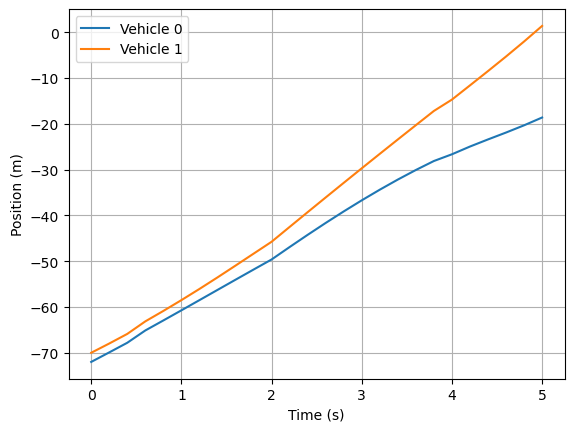

In [99]:
t_series = T*np.linspace(0,L-1,num=L)
%matplotlib inline
for i in range(2):
    plt.plot(t_series, X_hist[i,0,:], label = "Vehicle " + str(i))
plt.grid()
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')

Text(0, 0.5, 'Speed (m/s)')

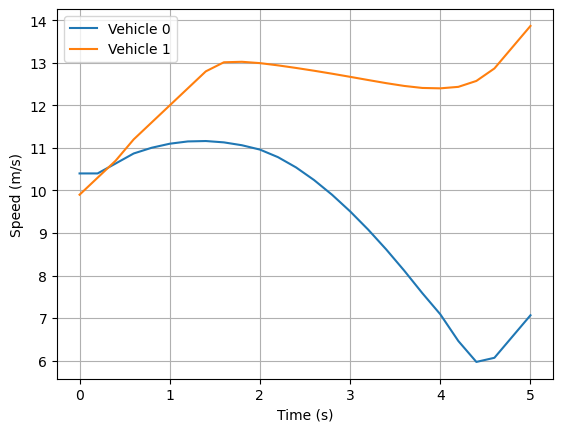

In [100]:
for i in range(2):
    plt.plot(t_series, X_hist[i,1,:], label = "Vehicle " + str(i))
plt.grid()
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')

In [101]:
def distance(p1, p2, angle):
    if p2 <= 0:
        dist = np.sqrt(p1**2 + p2**2 - 2*np.cos(angle)*p1*p2)
    elif p2 > 0:
        dist = np.abs(p1-p2)
    return dist
d = np.zeros(L)
for i in range(L):
    p1 = X_hist[0,0,i]; p2 = X_hist[1,0,i]
    d[i] = distance(p1, p2, np.pi/6)

Text(0, 0.5, 'Distance (m)')

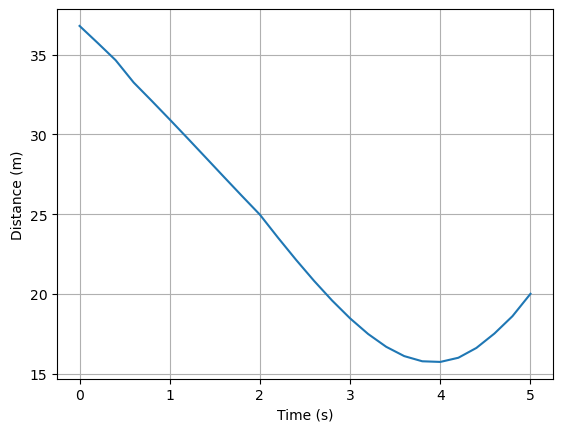

In [102]:
plt.plot(t_series, d, label = "Vehicle " + str(i))
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')

Text(0, 0.5, 'Speed (m/s)')

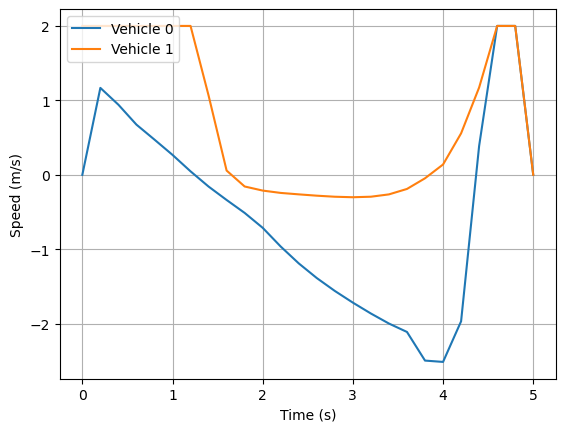

In [103]:
for i in range(2):
    plt.plot(t_series, X_hist[i,2,:], label = "Vehicle " + str(i))
plt.grid()
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')